# Projet Leyenda - Livrable 1 - Classification binaire

## Sommaire

* [1. Introduction](#chapiter1)
    * [1.1 Rappel du besoin](#section_1_1)
    * [1.2 Expression du besoin](#section_1_2)
    * [1.3 Contraintes](#section_1_3)
* [2. Configuration de l'environement](#chapter2)
    * [2.1 Import des librairies Python](#section_2_1)
    * [2.2 Utilisation du GPU](#section_2_2)
* [3. Préparation du dataset](#chapter3)
    * [3.1 Création d'un jeu d'entrainement et de test](#section_3_1)
    * [3.2 Augmentation des performances du dataset](#section_3_2)
    * [3.3 Data augmentation](#section_3_3)
    * [3.4 Visualisation des données](#section_3_4)
* [4.Création du modèle](#chapiter4)
* [4. Analyse des résultats](#chapiter4)
* [5. Amélioration du modèle](#chapiter5)
* [6. Conclusion](#chapitre6)

## 1. Introduction <a class="anchor" id="chapter1"></a>

### 1.1 Rappel du besoin <a class="anchor" id="section_1_1"></a>

<div style="text-align: justify">Dans le cadre de ce projet l'entreprise TouNum spécialisée dans la numérisation de documents souhaite étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, leur clientèle possédant une grande quantité de données à numériser au format papier. Dans le but de rester compétitif dans ce secteur d’activité l’entreprise décide d’innover et proposer un service de catégorisation qui serait plus que valorisable. Afin de mener à bien cette tâche, des spécialistes en Data Science de CESI ont été contactés.
<p>

L’objectif de cette première partie est d’automatiser la sélection des photos pour l’annotation. Pour ce faire, nous nous basons sur les réseaux de neurones afin de filtrer les images qui ne sont pas des photos dans le dataset de départ.<div>

### 1.2 Expression du besoin <a class="anchor" id="section_1_2"></a>

<div style="text-align: justify">Afin d’apporter une réponse adaptée à la problématique énoncée dans l’introduction de ce notebook. Il nous apparaît intéressant d’analyser le besoin de l’utilisateur final. Cette démarche a pour but de 
donner un point de vue global des attendus aux quelles la solution doit répondre. Ce qui nous 
donnera une ligne directrice à suivre tout au long de ce notebook. Afin, de donner un aperçu plus clair sur la marche à suivre pour répondre au besoin exprimé nous pouvons nous aider du diagramme bête à corne ci dessous.</div>

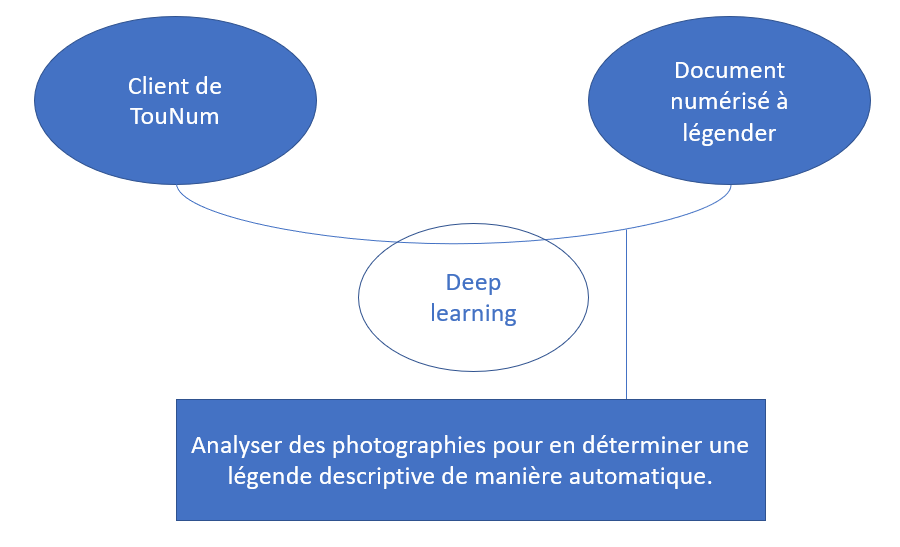
<center><em>Diagrame Bete à corne</em></center>

### 1.3 Contraintes <a class="anchor" id="section_1_3"></a>

<div style="text-align: justify">Cette première partie comporte plusieurs contraintes liées à la vision par ordinateur. En effet, nous devons être en capacité de déterminer si les images sont des photos sans tenir compte de l’orientation, de la luminosité, ou la  variation d’échelle de celles-ci. De plus, nous devrons extraire les features qui nous permettrons de distinguer les différences entre les types d’images qui composent le dataset.</div>  

## 2. Configuration de l'environement <a class="anchor" id="chapter2"></a>

<div style="text-align: justify">Dans cette partie nous mettrons en place le modèle de classification binaire dans le but de répondre au besoin exprimer précédemment. Pour ce faire nous reviendrons sur les différents différentes biothèques python utilisé toutes au long de notre notebook. Puis dans un second temps, nous éclaircirons chaque étape de notre modèle en justifiant les choix techniques. Pour finir, nous développerons les différentes méthodes qui nous ont permis d’augmenter la précision du modèle.</div>

### 2.1. Import des librairies Python <a class="anchor" id="section_2_1"></a>

Dans le cadre de ce premier livrable nous avons décidé d’importer plusieurs librairies python que nous allons présenter :
<ol>
    <li style="text-align: justify"><strong>TensorFlow</strong> : est un outil open source d'apprentissage automatique développé par Google. Il est l'un des outils les plus utilisés en IA dans le domaine de l'apprentissage machine. Celle-ci contient de nombreuses implémentations de blocs nécessaire à la construction de réseau de neurones couramment utilisés tels que des couches, des fonctions d'activation, des optimiseurs et une multitude d'outils pour faciliter le travail avec des images ou des textes afin de simplifier le codage nécessaire à l'écriture de code de réseau de neurones profond.</li> 
    <li style style="text-align: justify"><strong>NumPy</strong>: est une bibliothèque qui ajoute un support pour les tableaux et matrices multidimensionnels de grande taille, ainsi qu'une large collection de fonctions mathématiques de haut niveau pour opérer sur ces tableaux. Ceci nous permettra de travailler avec des images sous formes de matrice.</li>
    <li style style="text-align: justify"><strong>Scikit-learn</strong>: est une bibliothèque d'apprentissage automatique pour le langage de programmation Python. Elle propose divers algorithmes de classification, de régression et de regroupement. Dans le cadre de ce notebook nous l’utilisons pour valider les résultats de notre modèle.</li>
    
</ol>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

### 2.1. Utilisation du GPU <a class="anchor" id="section_2_2"></a>

<div style="text-align: justify">Dans l'optique d’avoir de meilleure performance tout aux longs de notebook notamment durant l’entrainement du modèle, nous avons décidé de faire passer le traitement des données par le GPU. Pour ce faire cette ligne nous indique si le système détecte un GPU qui peut être utilisé. (Seules les cartes Nvdia avec Cuda installé sont reconnus par Tensorflow)<div>

In [ ]:
tf.config.list_physical_devices()

## 3. Préparation du dataset <a class="anchor" id="Chapiter3"></a>

Nous chargeons en mémoire les différents variables utiles au modèle tel que la taille, ou le nombre d'images par batch. Cette segmentation du dataset en batch permet à la machine qui exécute le notebook de ne pas saturer sa mémoire. 

In [ ]:
data_dir = pathlib.Path("Class")
image_h = 180
image_w = 180
batch_s = 32

### 3.1 Création d'un jeu d'entrainement et de test <a class="anchor" id="section_3_1"></a>

<div style="text-align: justify">Pour préparer le jeu de données nous le séparons en deux sous-ensembles homogènes, afin d'éviter la sous-représentation de classe. Le premier sous-ensemble dit d'entrainement permettra au modèle d'ajuster ses poids et par conséquent améliorer sa classifcation. Le second nous permet d'évaluer la classification du modèle. C'est sur ce jeu de données qu'on se base pour le calcul de la précision du modèle.<div>   

In [ ]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="training",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  label_mode = "binary"
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="validation",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  label_mode = "binary"
)

Le code ci-dessous permet d'afficher les classes composant le Dataset

In [ ]:
class_names = train_set.class_names
print(class_names)

In [ ]:
for image_batch, labels_batch in train_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

### 3.2 Augmentation des performances du dataset <a class="anchor" id="section_3_2"></a>

Afin d'améliorer les performances du dataset nous pouvons mettre en place différentes méthodes:
- `Dataset.cache()`: Cette fonction nous permettra de garder les données dans la mémoire cache. En effet, notre modèle doit repasser plusieurs fois sur les données d'entrainement à chaque époque. De cette façon, le rechargement des données est grandement réduit entre chaque époque. 
- `Dataset.prefetch()`: Nous permet de paralléliser le traitement des batchs par le modèle. Pour ce faire, lors de l'entrainement/évaluation du batch en cours nous commençons le prétraitement du batch suivant.  

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

### 3.3 Data augmentation <a class="anchor" id="section_3_3"></a>

In [ ]:
#Fonction s'occupant de la data augmentation, aujoutant au dataset d'entrainement des images légèrements modifiées par leur orientation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(image_h, 
                                                              image_w,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

### 3.4 Visualisation des données <a class="anchor" id="section_3_4"></a>

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## 4 Création du Modèle <a class="anchor" id="chapiter4"></a>

Rajoutez ensuite l'augmentation des données à votre CNN et vérifiez les courbes obtenues après entrainement et évaluation du modèle.

In [ ]:
#def my_init(shape, dtype=None):     return K.random_normal(shape, dtype=tf.int32)

# Le modèle
complete_model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])
# Compilation du modèle
complete_model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])
# Résumé du modèle
complete_model.summary()

# Enrainement du modèle
epochs = 9
with tf.device('/device:GPU:0'):
  history = complete_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
  )

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## CALCUL DES INDICATEURS DE QUALITÉ : Matrice de confusion, Courbe ROC et L'air sous la courbe ROC

On affiche la matrice de confusion calculée sur nos données : On affiche la précision, le recall et le F1 Score 2 fois, une fois calculée avec la librairie et une fois calculée manuellement pour vérifier

In [ ]:
# from sklearn.metrics import classification_report

# predictions = complete_model.predict(test_set)
# predicted_categories = [1 * (x[0]>=0.5) for x in predictions]
# true_categories = tf.concat([y for x, y in test_set], axis=0)


# print(classification_report(true_categories, predicted_categories, target_names = class_names ))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

predictions = complete_model.predict(test_set)
predicted_categories = [1 * (x[0]>=0.5) for x in predictions]
true_categories = tf.concat([y for x, y in test_set], axis=0)

conf_matrix = confusion_matrix(true_categories, predicted_categories)
precision_score = precision_score(true_categories, predicted_categories)
recall_score = recall_score(true_categories, predicted_categories)
f1_score = f1_score(true_categories, predicted_categories)


TP = conf_matrix[1,1]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]
calc_precision_accuracy = TP/(TP+FP)
calc_recall_accuracy = TP/(TP+FN)


print(conf_matrix)
print("Precision score: "+str(precision_score)+" Recall Score: "+str(recall_score)+" F1 Score: "+str(f1_score))
print("Calculated precision score: "+str(calc_precision_accuracy)+" Calculated recall score: "+ str(calc_recall_accuracy))


In [ ]:
complete_model.evaluate(test_set)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, _ = roc_curve(true_categories, predicted_categories)

roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

La diagonal en pointillé représente la ROC d un classifier aléatoire. Un classificateur idéal s en écarte au maximum en épousant le coin supérieur gauche.

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(true_categories, predicted_categories)

On utilise comme métrique de comparaison l air sous la courbe ROC, que l on souhaite la plus proche possible de 1. On calcule donc le ROC AUC SCORE.

In [ ]:
complete_model.save('saved_model/my_model')


In [ ]:
from tensorflow.keras.models import load_model

complete_model = load_model('saved_model/my_model')

In [ ]:
from os import listdir
from os.path import isfile, join

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

from keras.preprocessing import image

onlyfiles = [f for f in listdir('images_test') if isfile(join('images_test', f))]

fig = plt.figure(figsize=(32, 32))
ax = []

for i in range(len(onlyfiles)):

  img = image.load_img('images_test/'+onlyfiles[i], target_size=(180, 180))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  plt.axis('off')
  
  #rendre ligne colonne dynamique par rapport au nb images dans le fichier
  ax.append( fig.add_subplot(math.ceil(len(onlyfiles)/3), 3, i+1) )

  images = np.vstack([x])
  classes = complete_model.predict(images, batch_size=10)

  if classes[0]<0.5:
    ax[-1].set_title(onlyfiles[i] + " n'est pas une photo")  # set title
  else:
    ax[-1].set_title(onlyfiles[i] + " est une photo")  # set title
  plt.imshow(img)


plt.show()


In [ ]:
path_dir = #chemin pour la création des fichiers
class_test = ['Photo','Autre']
if os.path.exists(path_dir) == False:
    os.mkdir(path_dir)
    class_predict = map(lambda x: os.path.join(path_dir, x), class_test)
    [os.mkdir(x) for x in class_predict]

In [ ]:
def load_image():
    path_data = #chemin contenant les photos à tester  
    onlyfiles = [os.path.join(path_data, f) for f in os.listdir(path_data) if os.path.isfile(os.path.join(path_data, f))]
    return onlyfiles

In [ ]:
model = keras.models.load_model(#chemin pour le model sauvegarde)
count = 0
list_file = load_image()
for file in list_file:
    img = image.load_img(file, target_size=(180, 180))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images)
    if classes[0]<0.5:
        img.save("{path}//{name}.png".format(path = os.path.join(path_dir, class_test[1]), name = file.split("\\")[1]), format='PNG')
    else:
        img.save("{path}//{name}.png".format(path = os.path.join(path_dir, class_test[0]), name = file.split("\\")[1]), format='PNG')
    count+=1